**목차**
* 결정트리
    * 결정트리 분류
        * 소개
        * 지니 불순도
        * 훈련 알고리즘
        * 오버피팅과 정규화
        * 레드 와인 품질 데이터 세트에 대한 결정 트리
    * 의사 결정 트리 회귀
        * 소개
        * 예
* 랜덤 포레스트
    * 랜덤 포레스트란?
    * 예 - Red Wine Quality 데이터 세트에 대한 무작위 포레스트 분류
    * 예시 - 와인 인식 데이터셋에 대한 랜덤 포레스트 회귀
* 부록: CART 알고리즘
    * 고정된 구조가 주어진 가중치 학습
    * 구조 학습
    * 가지치기|

In [1]:
import numpy as np
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import os
print(os.listdir("../input"))

['winequality-red.csv']


In [2]:
plt.rc('axes', lw = 1.5)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('xtick.major', size = 5, width = 3)
plt.rc('ytick.major', size = 5, width = 3)

# 결정트리
## 결정트리 분류
### Introdution


n개의 특성을 갖는 X 데이터세트를 가진다고 가정해보자. 그리고 각각의 데이터셋은 분류(class A, B C 라고 하자)를 가지고 있다. A 결정트리는 깊이가 2인 아래의 데이터셋처럼 훈련된다.
<img src="https://imgur.com/aJLCV2J.png" width="500px"/>

$k_1$ 특성은 임계값 $t_{k1}$을 통해 Class A로 분류된다. 다음으로 결정트리의 인스턴스 $k_2$가 임계값 $t_{k2}$보다 작거나 같은지 확인한다. 맞다면, 그 인스턴스는 Class B로 분류된다. 그렇지 않다면 Class C로 분류된다. 최상단 노드는 *root node*(깊이=0), 어느 자식 노드도 갖지 않는 노드를 *leaf node* 라고 한다.

결정트리를 사이킷런 모듈의 데이터셋을 이용해 적용해보자.

In [3]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data
y = wine.target

사이킷런의 `DecisionTreeClassifier`으로 결정트리를 훈련시켜보자.

In [4]:
tree = DecisionTreeClassifier(max_depth = 2, random_state = 0)
tree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

트리를 시각화하기 위해 `graphviz` 모듈이 필요하다. 

> import graphviz

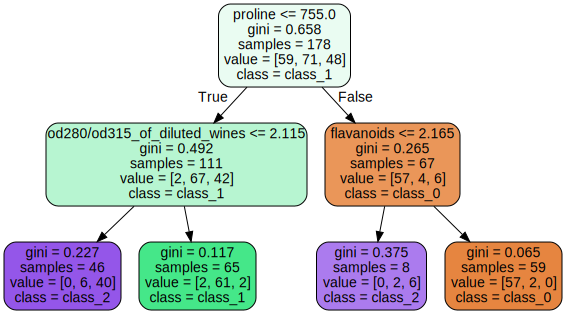

In [5]:
dot_data = export_graphviz(tree,
                out_file = None,
                feature_names = wine.feature_names,
                class_names=wine.target_names,
                rounded = True,
                filled = True)

graph = graphviz.Source(dot_data)
graph.render() 
graph

root node(깊이=0)는 분리 특성을 `proline`으로, 그리고 755.0을 임계값으로 골랐다. 깊이가 1인 두 노드는 `od280/od315_of_diluted_wines`, `flavanoids`을 분리 특성으로 골랐다. 깊이가 2인 4개의 leaf node 각각은 class를 예측했다. `gini`와 `value`와 같은 다른 속성도 확인할 수 있다. 

- `samples`는 각각의 노드에서 그 노드에서 얼마나 많은 훈련 인스턴스가 있는지 보여준다. 예를 들어, proline 755.0을 가지는 샘플은 67개가 있다.
- `value`는 각각의 노드에서 얼마나 많은 인스턴스가 class로 분류되었는지 보여준다. 예를 들어, 가장 왼쪽의 leaf node 에서 class_0에는 0개, class_1에는 6개, class_2에는 40개의 인스턴스가 있다.
- 각 노드에는 그 노드에 있는 객체의 비중에 기반한 `class`가 할당된다. 그러므로 root node가 세 class들의 객체들이 유사하게 있다고 해도, 71 > 59 > 48이기 때문에 root node의 클래스는 class_1이 된다.
- 예측을 생성하기 위해, 트리는 leaf node에 도달할 때까지 계속해야 한다.

### 지니 불순도
**지니 불순도**는 노드에 얼마나 순수한 샘플이 구성되어 있는지를 묘사한다. 예를 들어, 노드에 class_0 = 0, class_1 = 0, class_2 = 20 이라면 지니 불순도는 0일 것이다. 계산은 이렇다.

<center>
$G=1-\sum_{k=1}^{n}p_k^2$
</center>
$p_k$는 노드에 있는 class k의 인스턴스의 비율이다. 왼쪽 밑의 leaf node의 지니 불순도는 이렇다.
<center>
$G = 1 - (\frac{0}{46})^2 - (\frac{6}{46})^2 - (\frac{40}{46})^2 \approx 0.227.$    
</center>

### 알고리즘 훈련
분류기와 예측기 트리(CART) 알고리즘은 **한 노드를 두 개의 자식노드로 분리함**으로써 작동한다. 분리 기준은 아래의 불순도 비용함수를 최소화하는 값을 고르는 특성 $k$와 이 특성의 임계값 $t_k$로 구성된다.
<center>
    $J(k, t_k) = G_{\mathrm {left}}\times{m_{\mathrm {left}}}/{m}+ G_{\mathrm {right}}\times{m_{\mathrm {right}}}/{m}$
</center>

이는 **왼쪽 자식 노드와 오른쪽 자식 노드의 지니 불순도의 가중치의 합이다.** $G_{\mathrm {left}}$ ($G_{\mathrm {right}}$)는 왼쪽(오른쪽) 자식 노드의 지니 불순도이다. $m_{\mathrm {left}}$ ($m_{\mathrm {right}}$)는 왼쪽(오른쪽) 자식 노드의 샘플수이고, $m$는 부모 노드의 샘플 수이다. $m = m_{\mathrm {left}} + m_{\mathrm {right}}$ 알고리즘은 처음 root node를 두 노드로 나눌 것이다. 그리고 두 자식 노드를 각각 두 개로 나눌 것이다. 이 과정은 유저가 설정한 최대 깊이에 도달하면 멈춘다.혹은 나눈 후의 불순도 $G_{\mathrm {left}}\times{m_{\mathrm {left}}}/{m}+ G_{\mathrm {right}}\times{m_{\mathrm {right}}}/{m}$ 가 부모 노드의 불순도$G_{\mathrm{parent}}$보다 커지면 멈춘다. 하지만 다른 기준도 존재한다.

이 알고리즘과 사이킷런의 결정트리 분류기에 대한 정보:
- CART 알고리즘은 탐욕 알고리즘이다.
- 결정트리 분류기가 기본 세팅을 따른다면, 특성 훈련셋이 주어지면 결정론적인 결과가 예상된다. 하지만 결정트리 분류기는 무작위성을 보여준다. 왜냐하면 분류기가 무작위로 모든 특성을 re-order하고 각각을 테스트하기 때문이다. [github page](https://github.com/scikit-learn/scikit-learn/issues/8443) 에서 더 많은 정보를 찾을 수 있다.
- 훈련을 가속하기 위해서는 결정트리 분류기의 `max_feaures`를 특성의 총 개수보다 작게 설정해야 한다. 이 경우에 알고리즘은 특성의 무작위적으로 샘플된 부분집합으로부터 최적의 분할을 찾을 것이다.

### 과대적합과 규제
결정트리 분류기는 **규제가 없다면 쉽게 과대적합될 것이다**. 분류기는 100%의 정확도를 얻으려고 할 것이다. 우리는 결정트리의 과대적합을 살펴보고, 어떻게 고치는지 알아볼 것이다. 분류기를 `flavanoids`와 `proline` 두 특성으로 훈련할 것이다.

In [6]:
wine = load_wine()
X = wine.data[:,[6,12]] # flavanoids and proline
y = wine.target

# random_state is set to guarantee consistent result. You should remove it when running your own code.
tree1 = DecisionTreeClassifier(random_state=5) 
tree1.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='best')

다음과 같이 결정경계를 그릴 수 있다.

In [7]:
# preparing to plot the decision boundaries
x0min, x0max = X[:,0].min()-1, X[:,0].max()+1
x1min, x1max = X[:,1].min()-10, X[:,1].max()+10
xx0, xx1 = np.meshgrid(np.arange(x0min,x0max,0.02),np.arange(x1min, x1max,0.2))
Z = tree1.predict(np.c_[xx0.ravel(), xx1.ravel()])
Z = Z.reshape(xx0.shape)

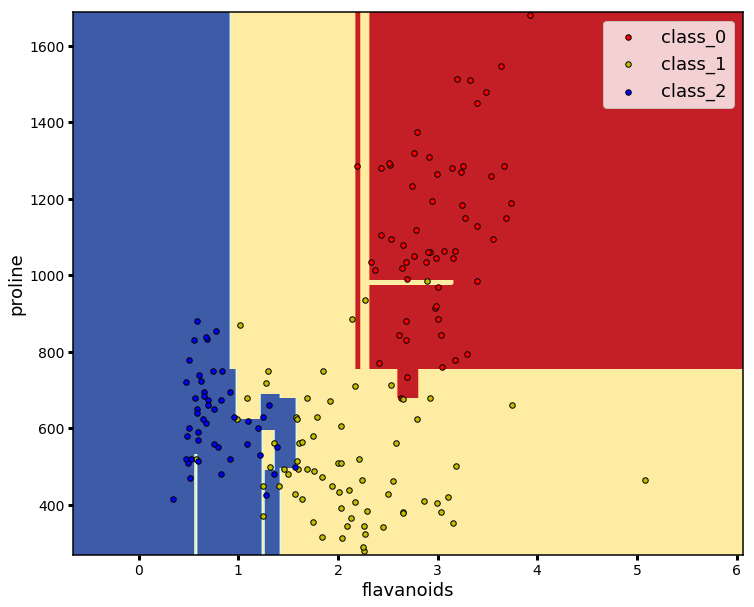

In [8]:
plt.subplots(figsize=(12,10))
plt.contourf(xx0, xx1, Z, cmap=plt.cm.RdYlBu)
plot_colors = "ryb"
n_classes = 3
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=wine.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=30)
plt.legend(fontsize=18)
plt.xlabel('flavanoids', fontsize = 18)
plt.ylabel('proline', fontsize = 18)
plt.show()

결정트리 분류기가 과대적합되었다. 비록 훈련셋을 완벽하게 맞추었지만, 일반적으로는 못할 것이다. 이 트리를 그리면 깊이가 8로 매우 깊은 트리를 볼 수 있다. 이 분류기를 규제하기 위해 적용할 수 있는 몇 가지 파라미터들이 있다.

* max_depth: 트리의 최대 깊이
* min_samples_split: 분할에 필요한 최소 샘플 개수
* min_samples_leaf: leaf node에 포함된 최소 샘플 개수
* max_leaf_nodes: 최대 leaf node의 개수
* max_features: 분할에 사용되는 특성의 개수

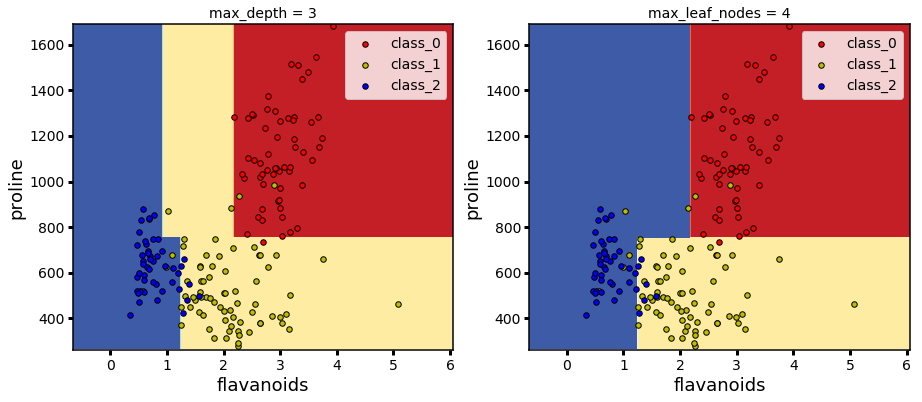

In [9]:
# limit maximum tree depth
tree1 = DecisionTreeClassifier(max_depth=3,random_state=5) 
tree1.fit(X,y)

# limit maximum number of leaf nodes
tree2 = DecisionTreeClassifier(max_leaf_nodes=4,random_state=5) 
tree2.fit(X,y)

x0min, x0max = X[:,0].min()-1, X[:,0].max()+1
x1min, x1max = X[:,1].min()-10, X[:,1].max()+10
xx0, xx1 = np.meshgrid(np.arange(x0min,x0max,0.02),np.arange(x1min, x1max,0.2))

Z1 = tree1.predict(np.c_[xx0.ravel(), xx1.ravel()])
Z1 = Z1.reshape(xx0.shape)
Z2 = tree2.predict(np.c_[xx0.ravel(), xx1.ravel()])
Z2 = Z2.reshape(xx0.shape)

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
ax[0].contourf(xx0, xx1, Z1, cmap=plt.cm.RdYlBu)
ax[1].contourf(xx0, xx1, Z2, cmap=plt.cm.RdYlBu)
plot_colors = "ryb"
n_classes = 3
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    ax[0].scatter(X[idx, 0], X[idx, 1], c=color, label=wine.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=30)
    ax[1].scatter(X[idx, 0], X[idx, 1], c=color, label=wine.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=30)
ax[0].legend(fontsize=14)
ax[0].set_xlabel('flavanoids', fontsize = 18)
ax[0].set_ylabel('proline', fontsize = 18)
ax[0].set_ylim(260,1690)
ax[0].set_title('max_depth = 3', fontsize = 14)
ax[1].legend(fontsize=14)
ax[1].set_xlabel('flavanoids', fontsize = 18)
ax[1].set_ylabel('proline', fontsize = 18)
ax[1].set_ylim(260,1690)
ax[1].set_title('max_leaf_nodes = 4', fontsize = 14)
plt.show()

최대 트리 깊이를 한정한 *tree1* 분류기와 최대 leaf node의 수를 제한한 *tree2* 분류기 둘 다 아무 규제가 없던 분류기에 비해 더 규제된 행동을 가진다. 규제된 분류기는 기본 분류기보다. 더 낮은 분산(더 적은 과대적합)과 더 높은 분산(과한 예측 에러)를 가진다. 결정트리 분류기가 테스트셋을 더 일반화할 수 있도록 항상 규제를 적용해야 한다. 하지만, 규제를 하거나 확장을 하는 파라미터는 특정 목표에 달려있다.

### Red Wine Quality 데이터셋의 결정트리 분류기
[logistic regression tutorial](https://www.kaggle.com/fengdanye/machine-learning-3-logistic-and-softmax-regression) 에서 사용했던 데이터셋을 이용해 결정 트리 분류기를 훈련할 것이다.

In [10]:
wineData = pd.read_csv('../input/winequality-red.csv')
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


1부터 7까지 와인을 좋음의 정도를 정의하고, 0은 좋지 않다 라고 정의해보자.

In [11]:
wineData['category'] = wineData['quality'] >= 7
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,False
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False


In [12]:
X = wineData[wineData.columns[0:11]].values
y = wineData['category'].values.astype(np.int)

데이터셋의 30프로를 테스트셋, 70프로를 훈련셋으로 나눈다. `random_state` 파라미터는 반복되는 결과를 고쳐준다.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print('X train size: ', X_train.shape)
print('y train size: ', y_train.shape)
print('X test size: ', X_test.shape)
print('y test size: ', y_test.shape)

X train size:  (1119, 11)
y train size:  (1119,)
X test size:  (480, 11)
y test size:  (480,)


위에서 말했듯이 분류기를 규제할 수 있는 여러 파라미터들이 있다.:
- max_features, max_depth, min_sampels_leaf

위 파라미터의 값의 다른 조합으로 분류기를 비교하기 위해 사이킷런의 **GridSearchCV** 함수를 사용할 수 있다. 

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
tuned_parameters = {'max_features': [0.5,0.6,0.7,0.8,0.9,1.0], 'max_depth': [2,3,4,5,6,7],'min_samples_leaf':[1,10,100],'random_state':[14]} 
# random_state is only to ensure repeatable results. You can remove it when running your own code.

clf = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 10, 100], 'random_state': [14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

최적의 모델과 훈련셋에 대한 성능을 출력해보자

In [16]:
print('The best model is: ', clf.best_params_)
print('This model produces a mean cross-validated score (auc) of', clf.best_score_)

The best model is:  {'max_depth': 6, 'max_features': 0.6, 'min_samples_leaf': 10, 'random_state': 14}
This model produces a mean cross-validated score (auc) of 0.8580851572127516


테스트셋에 대한 분류기의 성능을 보자.

In [17]:
from sklearn.metrics import precision_score, accuracy_score
y_true, y_pred = y_test, clf.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

precision on the evaluation set:  0.5576923076923077
accuracy on the evaluation set:  0.8729166666666667


- 55.8%가 좋은 와인으로 예측된다.
- 87.3%의 정확도를 가진다.

테스트셋의 ROC 곡선을 그려보고 AUC를 계산해보자.

In [18]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
phat = clf.predict_proba(X_test)[:,1]

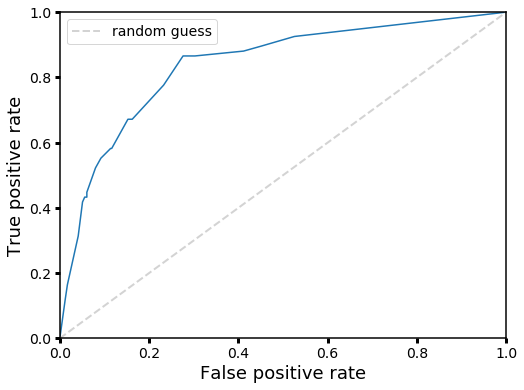

In [19]:
plt.subplots(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test, phat)
plt.plot(fpr, tpr)
x = np.linspace(0,1,num=50)
plt.plot(x,x,color='lightgrey',linestyle='--',marker='',lw=2,label='random guess')
plt.legend(fontsize = 14)
plt.xlabel('False positive rate', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [20]:
print('AUC is: ', auc(fpr,tpr))

AUC is:  0.8382422030284413



Basically, instead of penalizing impurity, decision tree regression algorithm penalizes mean squared errors (MSE). Let's look at an simple example:

## 결정트리 회귀
### Introduction
결정트리는 또한 회귀를 수행할 수 있다. 알고리즘은 특성 $k$와 임계값 $t_k$로 한 노드를 두 개의 자식 노드로 나눔으로써 작동한다. 하지만 다른 비중함수를 가지고 있다

<center>
    $J(k, t_k) = \mathrm {MSE_{left}}\times{m_{\mathrm {left}}}/{m}+ \mathrm {MSE_{right}}\times{m_{\mathrm {right}}}/{m}$
</center>
where
<center>
    $\mathrm {MSE_{left (right)}} =\frac{1}{m_{left(right)}} \sum_{i\in \mathrm{left (right)}}(\hat{y}_{\mathrm {left (right)}}-y^{(i)})^2$    
</center>
<center>
    $\hat{y}_{\mathrm{left(right)}} = \frac{1}{m_{\mathrm{left(right)}}} \sum_{i \in \mathrm{left(right)}} y^{(i)}$
</center>


훈련 과정은 아래에 설명된다:
- 알고리즘은 특성 $k$와 임계값 $t_k$를 고른다. 그리고 부모 노드로부터 왼쪽 노드($k$ values <= $t_k$), 오른쪽 노드($k$ values > $t_k$)로 샘플들을 분할한다.
- 왼쪽 노드의 $y$ value는 왼쪽 노드의 모든 샘플들의 $y$ value의 평균이다. 유사하게, 오른쪽 노드의 $y$ value는 오른쪽 노드의 모든 샘플들의 $y$ value의 평균이다.
- 알고리즘은 각 노드의 mse를 계산한다: $\mathrm{MSE_{left}}$ and $\mathrm{MSE_{right}}$.
- 알고리즘은 비용함수  $J(k, t_k)$를 최소화하기 위한 모든 가능한 ($k, t_k$)를 찾는다.
- 알고리즘은 자식 노드를 분할하기 위해 진행한다.

불순도 패널티를 주는 대신에, 기본적으로 결정트리 회귀 알고리즘은 mse를 적용한다. 예시를 봐보자.

### 예시


In [21]:
wine = load_wine()
x = wine.data[:,6] # flavanoids
y = wine.data[:,12] # proline

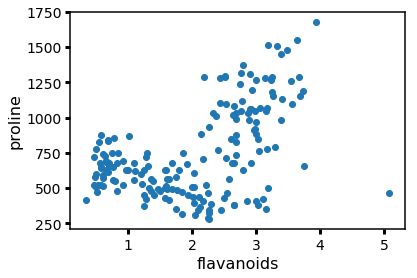

In [22]:
plt.scatter(x,y)
plt.xlabel('flavanoids',fontsize=16)
plt.ylabel('proline',fontsize=16)
plt.show()

결정트리를 동작시키기 위해 사이킷런의 **DecisionTreeRegressor** 함수를 사용할 수 있다.

In [23]:
x = x.reshape(-1,1)
tree = DecisionTreeRegressor(max_depth = 2, random_state = 5) # max tree depth is limited to 2
tree.fit(x,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=5, splitter='best')

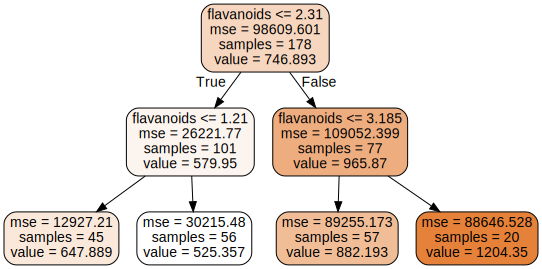

In [24]:
dot_data = export_graphviz(tree,
                out_file = None,
                feature_names = ['flavanoids'],
                rounded = True,
                filled = True)

graph = graphviz.Source(dot_data)
graph.render() 
graph

한 번 그려보자.

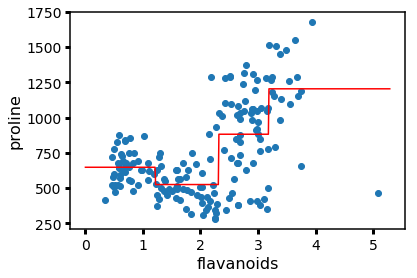

In [25]:
xx = np.arange(0,5.3, step = 0.01).reshape(-1,1)
yy = tree.predict(xx)

plt.scatter(x,y)
plt.plot(xx,yy,color='r')
plt.xlabel('flavanoids',fontsize=16)
plt.ylabel('proline',fontsize=16)
plt.show()

이 회귀기는 데이터를 대략적으로만 맞추고 있다. 트리의 깊이에 제약을 두지 않고 DecisionTreeRegressor를 사용해보자.

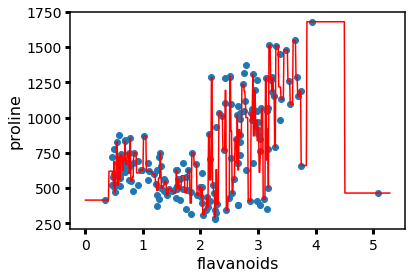

In [26]:
x = x.reshape(-1,1)
tree = DecisionTreeRegressor(random_state = 5)
tree.fit(x,y)

xx = np.arange(0,5.3, step = 0.01).reshape(-1,1)
yy = tree.predict(xx)

plt.scatter(x,y)
plt.plot(xx,yy,color='r')
plt.xlabel('flavanoids',fontsize=16)
plt.ylabel('proline',fontsize=16)
plt.show()

예상대로, 회귀기가 과대적합 되었다. 이상치에 매우 민감하고 모든 값에 대해 완벽하게 예측하려고 한다. 트리의 최대 깊이를 3으로 제한해보자.

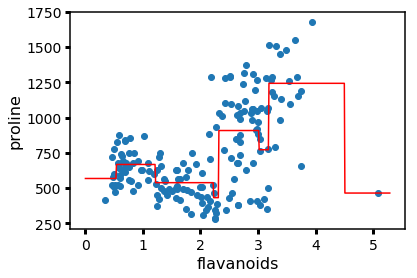

In [27]:
x = x.reshape(-1,1)
tree = DecisionTreeRegressor(max_depth = 3, random_state = 5)
tree.fit(x,y)

xx = np.arange(0,5.3, step = 0.01).reshape(-1,1)
yy = tree.predict(xx)

plt.scatter(x,y)
plt.plot(xx,yy,color='r')
plt.xlabel('flavanoids',fontsize=16)
plt.ylabel('proline',fontsize=16)
plt.show()

This is certainly better than the overfitting regressor, but would you say that it is a good fit? **One of the major characteristics of a decision tree is that it does not make any assumptions about your data**. This can be a problem sometimes. **A decision tree can be sensitive to outliers**, for example, as you can see in the above figure where the prediction line drops down just to fit the rightmost data point. If the data is noisy, **decision tree might not be able to distinguish between noise and signal**, since there is no underlying model (e.g. linear model, polynomial model) to guide the regression. 

Regularizing the tree can help with the above issues, but in some cases decision tree regessors just don't work well. In practice, it is a good idea to just try several possible regressors (decision tree, polynomial...) and choose the one that performs the best. An ensemble of decision trees (random forests) also tend to work better than individual trees, which we will talk about next.

**For more on the CART algorithm for tree training: see the newly added Appendix.**


이는 확실히 과대적합된 회귀기보다는 낫다. 하지만 정말 잘 훈련이 되었는가? 결정트리의 주요 특성 중 하나는 데이터에 대한 어느 가정도 만들지 않는다는 것이다. 가끔은 문제가 될 수도 있다. 예를들어, 결정트리는 이상치에 민감할 수 있다. 위 그림을 보면 가장 오른쪽 데이터 포인트에 맞추기 위해 예측 선이 급격히 내려간다. 만약 데이터에 노이즈가 있다면 결정트리는 회귀를 가이드하는 기본 모델이 없기 때문에 노이즈와 시그널 사이를 구분하지 못할 수 있다.

# 랜덤 포레스트
## 랜덤 포레스트란?
랜덤 포레스트는 결정 트리의 앙상블이다. 랜덤 포레스트에서 각 의사결정 트리는 훈련 세트의 무작위 하위 집합에 대해 훈련되며, 일반적으로 훈련 세트 크기와 동일한 샘플 크기로 교체로 샘플링된다. 분류의 경우 모든 트리에서 평균 확률이 가장 높은 클래스가 선택된다. 

사이킷런에서 랜덤 포레스트는 랜덤 포레스트 분류기와 랜덤포레스트 회귀기를 위해 사용한다. 랜덤 포레스트의 편향은 일반적으로 증가하지만, 분산은 이를 상쇄하여 전반적으로 더 좋은 모델을 얻는다. 

Red Wine Quality 데이터셋에 랜덤 포레스트를 적용해보자.

## 예제 - Red Wine Quality 데이터셋의 랜덤 포레스트 분류

In [28]:
wineData = pd.read_csv('../input/winequality-red.csv')

wineData['category'] = wineData['quality'] >= 7

X = wineData[wineData.columns[0:11]].values
y = wineData['category'].values.astype(np.int)

데이터셋을 훈련셋과 테스트셋으로 나눈다.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print('X train size: ', X_train.shape)
print('y train size: ', y_train.shape)
print('X test size: ', X_test.shape)
print('y test size: ', y_test.shape)

X train size:  (1119, 11)
y train size:  (1119,)
X test size:  (480, 11)
y test size:  (480,)


랜덤 포레스트 분류기를 훈련시키기 위해 `RandomForestClassifier`를 사용할 수 있다. `DecisionTreeClassifier`의 모든 파라미터를 가지고 있다. `GridSearchCV`를 사용해 `max_features` 와 `max_depth`같은 하이퍼파라미터의 조합을 테스트할 것이다.

`RandomForestClassifier`는 `n_estimators`와 `n_jobs` 같은 특이한 파라미터를 갖고 있다. `n_eistimators`는 포레스트의 트리의 수를 나타내고, `n_jobs`는 jobs의 수를 병렬로 수행한다.

In [30]:
tuned_parameters = {'n_estimators':[500],'n_jobs':[-1], 'max_features': [0.5,0.7,0.9], 'max_depth': [3,5,7],'min_samples_leaf':[1,10],'random_state':[14]} 
# random_state is only to ensure repeatable results. You can remove it when running your own code.

clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [500], 'n_jobs': [-1], 'max_features': [0.5, 0.7, 0.9], 'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 10], 'random_state': [14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

The training might take some time. After it's done, print out the best model and it's mean cross-validated AUC:

훈련은 아마 시간이 좀 걸릴 것이다. 끝나면 최적의 모델과 그 모델의 교차검증 AUC의 평균을 출력해보자.

In [31]:
print('The best model is: ', clf.best_params_)
print('This model produces a mean cross-validated score (auc) of', clf.best_score_)

The best model is:  {'max_depth': 7, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 14}
This model produces a mean cross-validated score (auc) of 0.8980094117408194


이제 이 모델의 테스트셋에 대한 성능을 볼 수 있다.

In [32]:
from sklearn.metrics import precision_score, accuracy_score
y_true, y_pred = y_test, clf.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

precision on the evaluation set:  0.5833333333333334
accuracy on the evaluation set:  0.8770833333333333


In [33]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
phat = clf.predict_proba(X_test)[:,1]

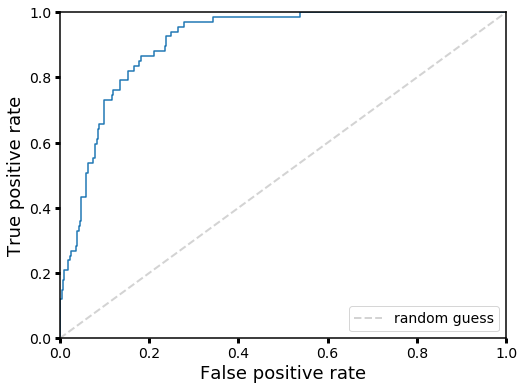

In [34]:
plt.subplots(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test, phat)
plt.plot(fpr, tpr)
x = np.linspace(0,1,num=50)
plt.plot(x,x,color='lightgrey',linestyle='--',marker='',lw=2,label='random guess')
plt.legend(fontsize = 14)
plt.xlabel('False positive rate', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [35]:
print('AUC is: ', auc(fpr,tpr))

AUC is:  0.908821509883994


결과는 단일 결정트리보다 훨씬 더 낫다.

## 예제 - wine recognition 데이터셋의 랜덤 포레스트 회귀
전에 테스트했던 결정트리 회귀기를 기억해보자.

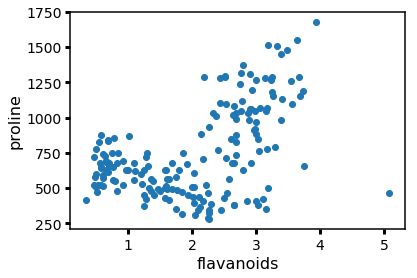

In [36]:
wine = load_wine()
x = wine.data[:,6] # flavanoids
y = wine.data[:,12] # proline

plt.scatter(x,y)
plt.xlabel('flavanoids',fontsize=16)
plt.ylabel('proline',fontsize=16)
plt.show()

같은 데이터셋에 랜덤 포레스트 회귀기를 적용해보자. 500개의 트리를 사용할 것이다. 각각의 트리는 최대 2의 깊이를 가지고 있다.

In [37]:
reg = RandomForestRegressor(n_estimators=500, n_jobs=-1, max_depth=2, random_state = 5)
x = x.reshape(-1,1)
reg.fit(x,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

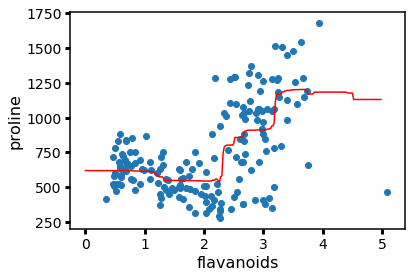

In [38]:
xx = np.arange(0,5,0.02).reshape(-1,1)
yhat = reg.predict(xx)
plt.plot(xx,yhat,color='red')
plt.scatter(x,y)
plt.xlabel('flavanoids',fontsize=16)
plt.ylabel('proline',fontsize=16)
plt.show()

예측이 훨신 스무스하다. 하지만 여전히 이상치에 영향을 받는다.

----------------------------------------------------
# 부록: CART 알고리즘

위에서 결정 트리 분류기(지니 불순도를 사용하는)들과 회귀기(mse를 사용하는)를 훈련시키기 위해 CART 알고리즘을 소개했다. CART 알고리즘을 더 일반적으로 소개할 것이다. 

CART 알고리즘은 한 번에 하나의 노드를 두 개의 자식 노드로 분리함으로써 트리를 훈련시킨다. 가능한 모든 분할의 각각의 단계(노드로 분리, 분리할 특성, 특성의 임계값) 사이에서, 훈련 오류를 최소화하는 하나를 고른다.

트리는 다음과 같이 표현될 수 있다.

<center>
$f(x) = \sum_{j=1}^{T} w_j {\mathrm I}(x\in R_j)$
</center>


$w_j$는 $j$번째 leaf node의 **가중치**라고 불리고, $\{R_j\} ( j=1,2,...,T)$ 는 트리의 **구조**라고 불린다. $T$는 이 트리의 leaf node들의 개수이다. ${\mathrm I}(x\in R_j)$는 만약 샘플 $x$가 $R_j$의  범위 안에 속한다면 0과 같고 아니면 1이다. 그러므로, $f(x)$는 만약 샘플 $x$가 $j$의 영역 안에 있다면 $w_j$를 예측할 것이다. 아래의 그림에서, $T=4$가 있다. 샘플 공간은 네 개의 서로소 영역으로 나뉜다.  $R_1=\{x: x\leq 1.21\}$, $R_2=\{x: 1.21 < x\leq 2.31\}$, $R_3=\{x: 2.31 < x \leq 3.185 \}$, and $R_4=\{x: x>3.185 \}$ $x$는 플라보노이드 값이다. 네 영역의 가중치는 $w_1=647.889$, $w_2=525.357$, $w_3=882.193$, and $w_4=1204.35$ 이다.

<img src="https://imgur.com/YDuPS3X.png" width="500px"/>


우리가 $n$개의 샘플을 훈련셋에 가지고 있다고 가정해보자. 우리의 목표는 비용 함수를 최소화하기 위해 트리를 훈련시키는 것이다.

<center>
$J(f)=\sum_{i=1}^{n}L(y_i, f(x_i))=\sum_{i=1}^{n}L(y_i, \sum_{j=1}^{T}w_j {\mathrm I}(x\in R_j))$
</center>

$y_i$는 샘플 $x_i$의 참이다. 일반적으로 훈련은 세 개의 단계로 구성된다: (1) 주어진 고정된 구조에 가중치를 학습; (2) 구조를 학습; (3) 가지치기

## 주어진 고정된 구조의 가중치 학습
영역 $R_j$의 분리된 특성과 모든 영역의 합집합이 완전한 표본 공간을 제공한다는 사실을 감안할 때 위의 비용 함수는 다음과 같이 추가로 작성할 수 있습니다.

<center>
$J(f)=\sum_{j=1}^{T}\sum_{x_i \in R_j}L(y_i, w_j)$
    
</center>
고정된 트리 구조(즉, 모든 $R_j$s가 정의 및 고정되어 있고 $T$가 고정되어 있음)에서 $J(f)$를 최소화하는 것은 $\sum_{x_i \in R_j}L(y_i, w_j)$를 최소화하는 것과 같습니다. 각 $j$에 대해. 따라서 고정된 구조가 주어지면

<center>
$w_j^* = \underset{w}{\operatorname{argmin}}\sum_{x_i \in R_j}L(y_i, w)$
</center>


<font color='blue'>제곱 손실 함수</font>의 경우 $w_j^* = \underset{w}{\operatorname{argmin}}\sum_{x_i \in R_j}(y_i-w) ^2$. $\frac{\partial \sum_{x_i \in R_j}(y_i-w)^2}{\partial w}$를 $0$로 설정하면 다음과 같습니다.


<center>
$w_j^* = \frac{\sum_{x_i \in R_j}y_i}{n_j}$
</center>

여기서 $n_j$는 $R_j$ 영역에 속하는 샘플의 수입니다. **즉, 제곱 손실 함수를 사용하면 추정 가중치 $w_j$는 단순히 $R_j$ 영역의 응답 평균입니다. 이것이 바로 의사 결정 트리 회귀 섹션**에서 설명한 것입니다. 손실 함수 $L$을 다르게 정의하면 $w_j^*$의 표현이 달라집니다. 예를 들어 절대 손실을 사용하는 경우입니다. 여기서 $L(y_i,w)=|y_i-w|$, $w_j^*$는 $R_j$ 영역에 있는 응답의 중앙값이어야 합니다.


## 구조 학습
이제 어떤 가중치에 구조를 부여해야 하는지 알았으므로 비용 함수는 다음과 같이 작성할 수 있습니다.
<center>
$J(f)=\sum_{j=1}^{T}\sum_{x_i \in R_j}L(y_i, w_j^*)  \equiv \sum_{j=1}^{T} L_j^*$
</center>

여기서 $L_j^*$는 리프 노드 $j$에서 집계된 손실이라고 합니다. **예상 무게 $w_j^*$가 사용됨**에 유의하십시오. 우리가 트리를 훈련하고 있고 리프 노드 $k$에서 다음 분할을 고려하고 있다고 상상해 보십시오. 이 침을 뱉기 전에 전체 비용은 다음과 같습니다.

<center>
$J_{\mathrm {before}}= \sum_{j\neq k} L_j^* + L_k^*$
</center>

리프 노드 $k$에서 분할한 후 왼쪽 자식 노드("L")와 오른쪽 자식 노드("R")를 얻습니다. 새 비용은 다음과 같습니다.

<center>
$J_{\mathrm {after}}= \sum_{j\neq k} L_j^* + L_L^*+L_R^*$
</center>


고려되는 분할의 <font color='blue'>이득</font>은 다음과 같이 정의됩니다.
<center>
${\mathrm {Gain}}=J_{\mathrm {before}} - J_{\mathrm {after}} = L_k^* - (L_L^*+L_R^*)$ 
</center>

이익이 클수록 비용 함수 $J$의 감소도 커집니다. **트리 학습의 모든 단계에서 가능한 모든 분할(분할할 노드, 분할할 기능, 기능의 임계값)에 대한 이득을 계산하고 이득을 최대화하는 분할을 선택합니다**. $L_k^*$는 다른 분할을 고려할 때 상수이므로 $(L_L^*+L_R^*)$를 최소화하면 됩니다. <font color='blue'>제곱 손실</font>의 경우에는 다음이 있습니다.
<center>
$L_L^*+L_R^* = \sum_{x_i \in \mathrm{left}}(y_i-\bar{y}_{\mathrm{left}})^2 + \sum_{x_i \in \mathrm{right}}(y_i-\bar{y}_{\mathrm{right}})^2 = n_{\mathrm{left}}\mathrm{MSE}_{\mathrm{left}} +  n_{\mathrm{right}}\mathrm{MSE}_{\mathrm{right}}$ 
</center>

여기서 $n_{\mathrm{left(right)}}$는 왼쪽(오른쪽) 노드의 훈련 샘플 수입니다. $\bar{y}_{\mathrm{left(right)}}$는 이전 단계에서 보여준 것처럼 제곱 손실 아래 왼쪽(오른쪽) 노드에 대한 추정 가중치입니다. **최소화할 이 양은 의사결정 트리 회귀 섹션에서 정의한 비용 함수 $J(k,t_k)$에 비례합니다. 즉, 해당 섹션에서 정의한 모든 것은 일반적인 CART 알고리즘이 제곱 손실로 적용되는 특정 사례일 뿐입니다.**

## 가지치기
트리 훈련 중에 가능한 모든 게인이 음수이면 분할을 포기할 수 있습니다. 그러나 이것은 현재 분할 후 추가 분할이 긍정적인 이익을 얻을 수 있고 전반적으로 비용을 감소시키기 때문에 너무 국지적인 결정일 수 있습니다. 이 문제를 해결하기 위해 일반적으로 트리는 특정 중지 기준이 충족될 때까지(예: 리프 노드의 최대 수에 도달할 때까지) 성장합니다. 성장 기간 동안 게인이 음수인 경우에도 각 단계에서 게인이 최대화된 최적화된 분할이 수행됩니다. **나무가 성장한 후 음수 이득을 가진 노드는 상향식 방식으로 제거되므로 전체 비용이 추가로 감소합니다**. 나무를 자르는 이 기술을 **가지치기**라고 합니다.

In tutorial 7, we will talk about tree boosting algorithms (gradient boosting machine and XGBoost). Understanding how the above algorithm works is important for understanding tree boosting. 

----------------------------------------------------------
Update Logs:  

**2019-01-18**
* I noticed a " timeout by a memory leak" warning while running GridSearchCV using RandomForestClassifier(). This problem did not happen in any of the previous commits. Somehow the computing capability of Kaggle platform changed in the past two weeks? Anyways, I have fixed the problem by reducing the searched parameters from "'max_features': [0.5,0.6,0.7,0.8,0.9,1.0], 'max_depth': [2,3,4,5,6,7],'min_samples_leaf':[1,10,100]" to "'max_features': [0.5,0.7,0.9], 'max_depth': [3,5,7],'min_samples_leaf':[1,10]". This does not affect the training outcome.
* Added an appendix to explain the CART algorithm for decision tree training. This is also important for understanding of the boosting algorithm introduced in Tutorial #7.

---------------------------------------------
Please upvote the notebook if you enjoyed this tutorial :) If you have any questions or comments, let me know!

For my previous tutorials, please see:
* [Machine Learning 1 - Regression, Gradient Descent](https://www.kaggle.com/fengdanye/machine-learning-1-regression-gradient-descent)
* [Machine Learning 2 Regularized LM, Early Stopping](https://www.kaggle.com/fengdanye/machine-learning-2-regularized-lm-early-stopping)
* [Machine Learning 3 Logistic and Softmax Regression](https://www.kaggle.com/fengdanye/machine-learning-3-logistic-and-softmax-regression)
* [Machine Learning 4 Support Vector Machine](https://www.kaggle.com/fengdanye/machine-learning-4-support-vector-machine)